In [105]:
import pandas as pd
import numpy as np
from plotnine import ggplot, geoms, theme, scales, ggtitle, labels
from plotnine import element_blank,element_line,element_rect,element_text

%matplotlib inline


In [168]:
snapshot = pd.read_csv('../../data/comparing_SCI-County/County_pop_over_SCI.csv')
pop_data = pd.read_csv('../../data/latest_data/Daily_Populations_aggregated.csv')

## Identifying discrepancies between SCI population reports from scraped snapshot data

It is likely that there will be inconsistencies between these two data sources. Specifically, see the following statement from the DOC:

<blockquote cite=http://inmatelocator.cor.pa.gov/#/>
The Pennsylvania Department of Corrections and Pennsylvania Board of Probation and Parole update this information daily. The Pennsylvania Department of Corrections and Pennsylvania Board of Probation and Parole make no representation as to the accuracy, completeness or utility of this information, and assume no liability for inaccurate information, delays in updating data, errors, omissions or for any use of the information provided herein.
</blockquote>

##### Snapshot Data
The current snapshot of the distribution of incarcerated peoples' (IC) by committing county over SCI was taken on `03/11/2021.` 

Snapshot Source: PA DOC inmate/parolee locator <a href= http://inmatelocator.cor.pa.gov/#/> http://inmatelocator.cor.pa.gov/#/</a>

the snapshot has three useful fields
* county: the committing county of the offense, $c_1 . . . c_i$
* location: SCI, $l_1 . . . l_j$
* incarcerated persons: the number of incarcerated people in SCI $l_j$ who committed offense in county $c_i$. 

##### Population Report Data
The population data reported here spans `04/07/2020 - 03/10/2021`. Here we use the most recent date (`03/10/2021`) for our comparison. The date discrepancy is one potential source of uncertainty with the current comparison. 

### Prepare data for comparison

In [185]:
pop_data['date'] = pd.to_datetime(pop_data['date'])
latest_pop = (pop_data.loc[pop_data['date'] == pop_data['date'].max(),['SCI','population']])
latest_pop['SCI'] = latest_pop['SCI'].str.title()
latest_pop['source'] = "DOC Reports"

In [170]:
latest_pop.head()

,SCI,population,source
8550,Albion,2133.0,DOC Reports
8551,Benner,1964.0,DOC Reports
8552,Camp Hill,2017.0,DOC Reports
8553,Cambridge Springs,879.0,DOC Reports
8554,Chester,1021.0,DOC Reports


In [186]:
snapshot['SCI'] = snapshot['location'].str.title()
snapshot['county'] = snapshot['county'].str.title()
snapshot_summed = (snapshot[['county','SCI','incarcerated_persons']]
                   .groupby('SCI')
                   .sum()
                   .reset_index())

snapshot_summed.columns = ['SCI','population']
snapshot_summed['source'] = 'snapshot'

In [187]:
snapshot_summed.head()

,SCI,population,source
0,Albion,2066,snapshot
1,Benner Township,1885,snapshot
2,Cambridge Springs,860,snapshot
3,Camp Hill,1886,snapshot
4,Chester,981,snapshot


<strong>Need to make sure that all SCI names are consistent</strong>

In [188]:
[i for i in snapshot_summed['SCI'] if i not in list(latest_pop['SCI'])]

['Benner Township', 'Quehanna Boot Camp']

In [189]:
snapshot_summed.loc[snapshot_summed.SCI == "Benner Township",'SCI'] = 'Benner'
snapshot_summed.loc[snapshot_summed.SCI == "Quehanna Boot Camp",'SCI'] = 'Quehanna'

In [190]:
[i for i in snapshot_summed['SCI'] if i not in list(latest_pop['SCI'])]

[]

#### Merge sources

In [191]:
pops_merged = pd.merge(snapshot_summed,latest_pop,on='SCI',how='inner')
pops_merged = pops_merged[['SCI','population_x','population_y']]
pops_merged.columns = ['SCI','snapshot','DOC report']

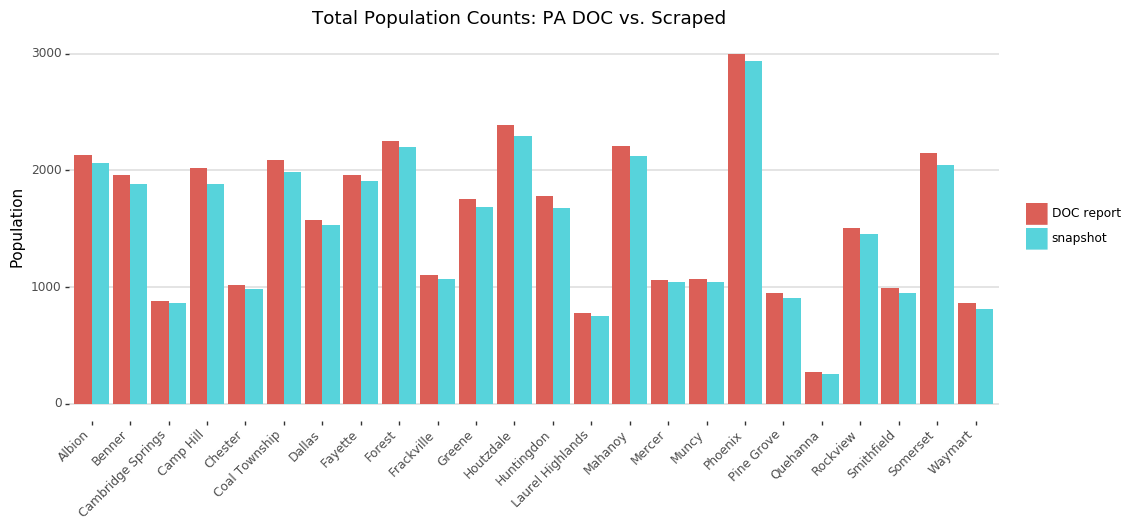

<ggplot: (320073245)>

In [192]:
(
    ggplot(pops_merged.melt(id_vars='SCI'),aes(x = "SCI",y='value',fill='variable')) +
    geoms.geom_bar(stat='identity',position='dodge') + 
    theme(figure_size=(12,5),
         axis_text_x = element_text(angle = 45, hjust = 1),
         panel_background=element_blank(),
         panel_grid_major_y=element_line(color='grey',size=0.3),
         legend_title=element_blank()) +
    ggtitle("Total Population Counts: PA DOC vs. Scraped") +
    labels.xlab('') +
    labels.ylab('Population')
)


<strong> The Snapshot and DOC Reported population data seem to be very similar. This provides credibility to the data scraped from the inmate/parolee locater. </strong>

<hr>

## Distributions of committing counties over SCI

In [193]:
def get_proportion(v):
    summ = v.sum()
    return v/summ

snapshot['proportion_by_sci'] = snapshot.groupby('SCI')['incarcerated_persons'].apply(get_proportion)

In [194]:
# check taht groupby apply worked
snapshot.groupby('SCI').proportion_by_sci.sum()

SCI
Albion                1.0
Benner Township       1.0
Cambridge Springs     1.0
Camp Hill             1.0
Chester               1.0
Coal Township         1.0
Dallas                1.0
Fayette               1.0
Forest                1.0
Frackville            1.0
Greene                1.0
Houtzdale             1.0
Huntingdon            1.0
Laurel Highlands      1.0
Mahanoy               1.0
Mercer                1.0
Muncy                 1.0
Phoenix               1.0
Pine Grove            1.0
Quehanna Boot Camp    1.0
Rockview              1.0
Smithfield            1.0
Somerset              1.0
Waymart               1.0
Name: proportion_by_sci, dtype: float64

In [195]:
def print_top(x):
    _sorted = x.sort_values(by = 'proportion_by_sci',ascending=False)
    return _sorted[['county','SCI','incarcerated_persons','proportion_by_sci']].head()


In [196]:
print_top(
    snapshot.loc[snapshot['SCI'] == "Phoenix"]
)

,county,SCI,incarcerated_persons,proportion_by_sci
1241,Philadelphia,Phoenix,1330,0.452689
545,Delaware,Phoenix,237,0.080667
1097,Montgomery,Phoenix,161,0.054799
209,Bucks,Phoenix,141,0.047992
353,Chester,Phoenix,120,0.040844


In [210]:
snapshot.loc[snapshot['county'] == "Philadelphia",['county','SCI','incarcerated_persons','proportion_by_sci']].sort_values(by='proportion_by_sci',ascending=False)

,county,SCI,incarcerated_persons,proportion_by_sci
1241,Philadelphia,Phoenix,1330,0.452689
1230,Philadelphia,Dallas,610,0.398172
1233,Philadelphia,Frackville,390,0.365511
1238,Philadelphia,Mahanoy,734,0.345249
1236,Philadelphia,Huntingdon,576,0.343266
1229,Philadelphia,Coal Township,630,0.316742
1228,Philadelphia,Chester,290,0.295617
1244,Philadelphia,Rockview,416,0.286304
1232,Philadelphia,Forest,601,0.273555
1246,Philadelphia,Somerset,548,0.267578
